## 基于InceptionV4模型实现扑克牌识别

该项目是基于InceptionV4算法，实现53种扑克牌识别，可以用在智能眼镜扑克牌游戏中，由于种类比较多，就不在这里一一列举了。

### 环境准备

In [1]:
%%capture captured_output
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


### 超参设置

In [3]:
batch_size = 32  # 批量大小
image_size = 299  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 53  # 分类数量

### 数据集下载及数据处理

通过git下载魔乐平台的数据集。

In [5]:
!git lfs install
!git clone https://modelers.cn/xsir/pukepai.git
!unzip -q pukepai/dataset.zip -d ./pukepai/dataset

Git LFS initialized.
正克隆到 'pukepai'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (7/7), 完成.
处理 delta 中: 100% (1/1), 完成.


In [13]:
import os

train_dir = './pukepai/dataset/train'

# 获取所有子文件夹名称并排序（不区分大小写）
num_classes = [entry.name for entry in os.scandir(train_dir) if entry.is_dir()]
num_classes.sort(key=lambda x: x.lower())

print("Classes列表:", num_classes)  # 可选，用于验证结果

Classes列表: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


In [9]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from typing import Type, Union, List, Optional
from mindspore import nn, train
from mindspore.common.initializer import Normal
import os
import time
# 数据集目录路径
data_path_train = "./pukepai/dataset/train/"
data_path_val = "./pukepai/dataset/val/"

# 创建训练数据集

def create_dataset_canidae(dataset_path, usage):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)

    # 数据增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    scale = 32

    if usage == "train":
        # Define map operations for training dataset
        trans = [
            vision.RandomCropDecodeResize(size=image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        # Define map operations for inference dataset
        trans = [
            vision.Decode(),
            vision.Resize(image_size + scale),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]


    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)


    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set


dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Image shape: (32, 3, 299, 299), Label shape: (32,)
Labels: [44 36 48 14 45 38]


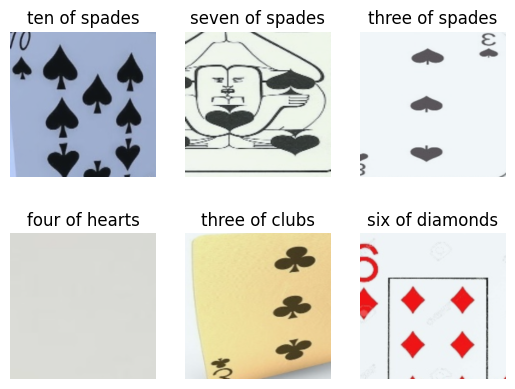

In [14]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# 训练数据集中，前六张图片所对应的标签
print(f"Labels: {labels[:6]}")


# 训练数据集的前六张图片
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{num_classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

### InceptionV4模型
有关InceptionV4网络的详细情况可以参考论文https://arxiv.org/abs/1602.07261

In [11]:
import mindspore.nn as nn
from mindspore.ops import operations as P

class Avgpool(nn.Cell):
    """Avgpool"""
    def __init__(self, kernel_size, stride=1, pad_mode='same'):
        super(Avgpool, self).__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride, pad_mode=pad_mode)

    def construct(self, x):
        x = self.avg_pool(x)
        return x


class Conv2d(nn.Cell):
    """
    Set the default configuration for Conv2dBnAct
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, pad_mode='valid', padding=0,
                 has_bias=False, weight_init="XavierUniform", bias_init='zeros'):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2dBnAct(in_channels, out_channels, kernel_size, stride=stride, pad_mode=pad_mode,
                                   padding=padding, weight_init=weight_init, bias_init=bias_init, has_bias=has_bias,
                                   has_bn=True, activation="relu")

    def construct(self, x):
        x = self.conv(x)
        return x

class Stem(nn.Cell):
    """
    Inceptionv4 stem

    """
    def __init__(self, in_channels):
        super(Stem, self).__init__()
        self.conv2d_1a_3x3 = Conv2d(
            in_channels, 32, 3, stride=2, padding=0, has_bias=False)

        self.conv2d_2a_3x3 = Conv2d(
            32, 32, 3, stride=1, padding=0, has_bias=False)
        self.conv2d_2b_3x3 = Conv2d(
            32, 64, 3, stride=1, pad_mode='pad', padding=1, has_bias=False)

        self.mixed_3a_branch_0 = nn.MaxPool2d(3, stride=2)
        self.mixed_3a_branch_1 = Conv2d(
            64, 96, 3, stride=2, padding=0, has_bias=False)

        self.mixed_4a_branch_0 = nn.SequentialCell([
            Conv2d(160, 64, 1, stride=1, padding=0, has_bias=False),
            Conv2d(64, 96, 3, stride=1, padding=0, pad_mode='valid', has_bias=False)])

        self.mixed_4a_branch_1 = nn.SequentialCell([
            Conv2d(160, 64, 1, stride=1, padding=0, has_bias=False),
            Conv2d(64, 64, (1, 7), pad_mode='same', stride=1, has_bias=False),
            Conv2d(64, 64, (7, 1), pad_mode='same', stride=1, has_bias=False),
            Conv2d(64, 96, 3, stride=1, padding=0, pad_mode='valid', has_bias=False)])



        self.mixed_5a_branch_0 = Conv2d(
            192, 192, 3, stride=2, padding=0, has_bias=False)
        self.mixed_5a_branch_1 = nn.MaxPool2d(3, stride=2)
        self.concat0 = P.Concat(1)
        self.concat1 = P.Concat(1)
        self.concat2 = P.Concat(1)

    def construct(self, x):
        """construct"""
        x = self.conv2d_1a_3x3(x)  # 149 x 149 x 32
        x = self.conv2d_2a_3x3(x)  # 147 x 147 x 32
        x = self.conv2d_2b_3x3(x)  # 147 x 147 x 64

        x0 = self.mixed_3a_branch_0(x)
        x1 = self.mixed_3a_branch_1(x)
        x = self.concat0((x0, x1))  # 73 x 73 x 160

        x0 = self.mixed_4a_branch_0(x)
        x1 = self.mixed_4a_branch_1(x)
        x = self.concat1((x0, x1))  # 71 x 71 x 192

        x0 = self.mixed_5a_branch_0(x)
        x1 = self.mixed_5a_branch_1(x)
        x = self.concat2((x0, x1))  # 35 x 35 x 384
        return x

class InceptionA(nn.Cell):
    """InceptionA"""
    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        self.branch_0 = Conv2d(
            in_channels, 96, 1, stride=1, padding=0, has_bias=False)
        self.branch_1 = nn.SequentialCell([
            Conv2d(in_channels, 64, 1, stride=1, padding=0, has_bias=False),
            Conv2d(64, 96, 3, stride=1, pad_mode='pad', padding=1, has_bias=False)])

        self.branch_2 = nn.SequentialCell([
            Conv2d(in_channels, 64, 1, stride=1, padding=0, has_bias=False),
            Conv2d(64, 96, 3, stride=1, pad_mode='pad',
                   padding=1, has_bias=False),
            Conv2d(96, 96, 3, stride=1, pad_mode='pad', padding=1, has_bias=False)])

        self.branch_3 = nn.SequentialCell([
            Avgpool(kernel_size=3, stride=1, pad_mode='same'),
            Conv2d(384, 96, 1, stride=1, padding=0, has_bias=False)])

        self.concat = P.Concat(1)

    def construct(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        x4 = self.concat((x0, x1, x2, x3))
        return x4

class InceptionB(nn.Cell):
    """InceptionB"""
    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch_0 = Conv2d(in_channels, 384, 1,
                               stride=1, padding=0, has_bias=False)
        self.branch_1 = nn.SequentialCell([
            Conv2d(in_channels, 192, 1, stride=1, padding=0, has_bias=False),
            Conv2d(192, 224, (1, 7), pad_mode='same',
                   stride=1, has_bias=False),
            Conv2d(224, 256, (7, 1), pad_mode='same',
                   stride=1, has_bias=False),
        ])
        self.branch_2 = nn.SequentialCell([
            Conv2d(in_channels, 192, 1, stride=1, padding=0, has_bias=False),
            Conv2d(192, 192, (7, 1), pad_mode='same',
                   stride=1, has_bias=False),
            Conv2d(192, 224, (1, 7), pad_mode='same',
                   stride=1, has_bias=False),
            Conv2d(224, 224, (7, 1), pad_mode='same',
                   stride=1, has_bias=False),
            Conv2d(224, 256, (1, 7), pad_mode='same', stride=1, has_bias=False)
        ])
        self.branch_3 = nn.SequentialCell([
            Avgpool(kernel_size=3, stride=1, pad_mode='same'),
            Conv2d(in_channels, 128, 1, stride=1, padding=0, has_bias=False)
        ])
        self.concat = P.Concat(1)

    def construct(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        x4 = self.concat((x0, x1, x2, x3))
        return x4

class ReductionA(nn.Cell):
    """ReductionA"""
    def __init__(self, in_channels, k, l, m, n):
        super(ReductionA, self).__init__()
        self.branch_0 = Conv2d(in_channels, n, 3, stride=2, padding=0)
        self.branch_1 = nn.SequentialCell([
            Conv2d(in_channels, k, 1, stride=1, padding=0, has_bias=False),
            Conv2d(k, l, 3, stride=1, pad_mode='pad',
                   padding=1, has_bias=False),
            Conv2d(l, m, 3, stride=2, padding=0, has_bias=False),
        ])
        self.branch_2 = nn.MaxPool2d(3, stride=2)
        self.concat = P.Concat(1)

    def construct(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.concat((x0, x1, x2))
        return x3         # 17 x 17 x 1024

class ReductionB(nn.Cell):
    """ReductionB"""
    def __init__(self, in_channels):
        super(ReductionB, self).__init__()
        self.branch_0 = nn.SequentialCell([
            Conv2d(in_channels, 192, 1, stride=1, padding=0, has_bias=False),
            Conv2d(192, 192, 3, stride=2, padding=0, has_bias=False),
        ])
        self.branch_1 = nn.SequentialCell([
            Conv2d(in_channels, 256, 1, stride=1, padding=0, has_bias=False),
            Conv2d(256, 256, (1, 7), pad_mode='same',
                   stride=1, has_bias=False),
            Conv2d(256, 320, (7, 1), pad_mode='same',
                   stride=1, has_bias=False),
            Conv2d(320, 320, 3, stride=2, padding=0, has_bias=False)
        ])
        self.branch_2 = nn.MaxPool2d(3, stride=2)
        self.concat = P.Concat(1)

    def construct(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.concat((x0, x1, x2))
        return x3     # 8 x 8 x 1536

class InceptionC(nn.Cell):
    """InceptionC"""
    def __init__(self, in_channels):
        super(InceptionC, self).__init__()
        self.branch_0 = Conv2d(in_channels, 256, 1,
                               stride=1, padding=0, has_bias=False)

        self.branch_1 = Conv2d(in_channels, 384, 1,
                               stride=1, padding=0, has_bias=False)
        self.branch_1_1 = Conv2d(
            384, 256, (1, 3), pad_mode='same', stride=1, has_bias=False)
        self.branch_1_2 = Conv2d(
            384, 256, (3, 1), pad_mode='same', stride=1, has_bias=False)

        self.branch_2 = nn.SequentialCell([
            Conv2d(in_channels, 384, 1, stride=1, padding=0, has_bias=False),
            Conv2d(384, 448, (3, 1), pad_mode='same',
                   stride=1, has_bias=False),
            Conv2d(448, 512, (1, 3), pad_mode='same',
                   stride=1, has_bias=False),
        ])
        self.branch_2_1 = Conv2d(
            512, 256, (1, 3), pad_mode='same', stride=1, has_bias=False)
        self.branch_2_2 = Conv2d(
            512, 256, (3, 1), pad_mode='same', stride=1, has_bias=False)

        self.branch_3 = nn.SequentialCell([
            Avgpool(kernel_size=3, stride=1, pad_mode='same'),
            Conv2d(in_channels, 256, 1, stride=1, padding=0, has_bias=False)
        ])
        self.concat0 = P.Concat(1)
        self.concat1 = P.Concat(1)
        self.concat2 = P.Concat(1)

    def construct(self, x):
        """construct"""
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x1_1 = self.branch_1_1(x1)
        x1_2 = self.branch_1_2(x1)
        x1 = self.concat0((x1_1, x1_2))
        x2 = self.branch_2(x)
        x2_1 = self.branch_2_1(x2)
        x2_2 = self.branch_2_2(x2)
        x2 = self.concat1((x2_1, x2_2))
        x3 = self.branch_3(x)
        return self.concat2((x0, x1, x2, x3))  # 8 x 8 x 1536

class Inceptionv4(nn.Cell):
    """
    Inceptionv4 architecture

    Args.
        is_train : in train mode, turn on the dropout.

    """
    def __init__(self, in_channels=3, classes=1000, k=192, l=224, m=256, n=384, is_train=True):
        super(Inceptionv4, self).__init__()
        blocks = []
        blocks.append(Stem(in_channels))
        for _ in range(4):
            blocks.append(InceptionA(384))
        blocks.append(ReductionA(384, k, l, m, n))
        for _ in range(7):
            blocks.append(InceptionB(1024))
        blocks.append(ReductionB(1024))
        for _ in range(3):
            blocks.append(InceptionC(1536))
        self.features = nn.SequentialCell(blocks)

        self.avgpool = P.ReduceMean(keep_dims=False)
        self.softmax = nn.DenseBnAct(
            1536, classes, weight_init="XavierUniform", has_bias=True, has_bn=True, activation="logsoftmax")
        if is_train:
            self.dropout = nn.Dropout(p=0.8)
        else:
            self.dropout = nn.Dropout(p=0.0)
        self.bn0 = nn.BatchNorm1d(1536, eps=0.001, momentum=0.1)


    def construct(self, x):
        x = self.features(x)
        x = self.avgpool(x, (2, 3))
        x = self.bn0(x)
        x = self.dropout(x)
        x = self.softmax(x)
        return x


### 模型训练
跑了100epochs训练结果如下:

In [12]:
network = Inceptionv4(classes=53)

In [19]:
# 设置学习率
num_epochs = 100
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss


grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)


def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

In [20]:
import os

# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/inceptionv4-best.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)

In [21]:
import mindspore.ops as ops


def train(data_loader, epoch):
    """模型训练"""
    losses = []
    network.set_train(True)

    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels)
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    """模型验证"""
    network.set_train(False)

    correct_num = 0.0  # 预测正确个数
    total_num = 0.0  # 预测总数

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # 预测结果
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # 准确率

    return acc

In [22]:
# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)
    if (epoch + 1) % 10 == 0:
        print("-" * 50)
        print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
            epoch+1, num_epochs, curr_loss, curr_acc
        ))

    # 保存当前预测准确率最高的模型
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...
--------------------------------------------------
Epoch: [ 10/100], Average Train Loss: [3.065], Accuracy: [0.268]
--------------------------------------------------
Epoch: [ 20/100], Average Train Loss: [2.809], Accuracy: [0.358]
--------------------------------------------------
Epoch: [ 30/100], Average Train Loss: [2.642], Accuracy: [0.445]
--------------------------------------------------
Epoch: [ 40/100], Average Train Loss: [2.522], Accuracy: [0.491]
--------------------------------------------------
Epoch: [ 60/100], Average Train Loss: [2.268], Accuracy: [0.574]
--------------------------------------------------
Epoch: [ 70/100], Average Train Loss: [2.182], Accuracy: [0.634]
--------------------------------------------------
Epoch: [ 80/100], Average Train Loss: [2.081], Accuracy: [0.668]
--------------------------------------------------
Epoch: [ 90/100], Average Train Loss: [2.043], Accuracy: [0.683]
------------------------------------------------

### 可视化模型预测
定义`visualize_model`函数，使用上述验证精度最高的模型对测试数据集进行预测，并将预测结果可视化。若预测字体颜色为蓝色表示为预测正确，预测字体颜色为红色则表示预测错误。

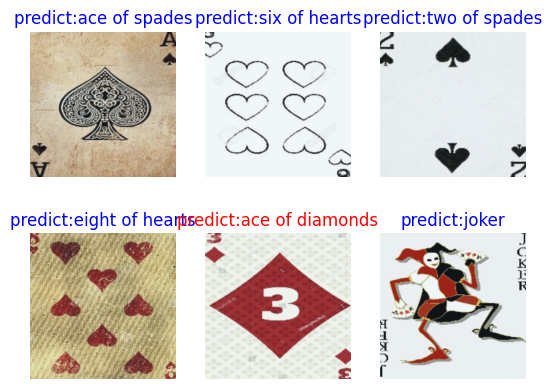

In [23]:
import matplotlib.pyplot as plt


def visualize_model(best_ckpt_path, dataset_val):
    net = Inceptionv4(classes=53)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"]
    labels = data["label"]
    # 预测图像类别
    output = net(data['image'])
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
        plt.title('predict:{}'.format(num_classes[pred[i]]), color=color)
        picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)